### Instalando pydataxm - API XM



In [87]:
#!pip install pydataxm

### Importando Librerias

In [101]:
from pydataxm import *
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import os
import seaborn as sns

### Obteniendo datos de la API XM

In [89]:
# https://github.com/EquipoAnaliticaXM/API_XM

objAPI= pydataxm.ReadDB() # Objeto API XM
df_metricas=objAPI.get_collections() # Obteniendo listado de metricas disponibles asociadas a Aportes
df_metricas.head()

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
0,DemaReal,Demanda Real por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...
1,DemaReal,Demanda Real por Agente,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...
2,ExpoMoneda,Exportaciones Moneda por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP,Transferencias de Energia desde Colombia hacia...
3,DemaCome,Demanda Comercial por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...
4,Gene,Generación por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...


#### Consultando las metrica de interes

In [90]:
def get_data(metrica,fi=dt.date(2000,1,1),ff=dt.date(2025,1,31)):
  objAPI= pydataxm.ReadDB() # Objeto API XM
  df=objAPI.request_data(
    metrica,'Rio',fi,ff
  ) # Consulta de información
  df=df[df['Name']=='NARE']
  df.drop(columns=['Id'],inplace=True)
  df['Value']=round(df['Value'],3) # Unidades en GWh
  df.rename(columns={'Value':metrica},inplace=True)

  return df

In [91]:
df=get_data('AporCaudal')
df.head()

,Name,AporCaudal,Date
14,NARE,43.51,2000-01-01
32,NARE,43.67,2000-01-02
50,NARE,41.21,2000-01-03
68,NARE,43.80,2000-01-04
86,NARE,40.62,2000-01-05


In [92]:
df.isna().sum()

Name          0
AporCaudal    0
Date          0
dtype: int64

### Periodos del niño significativos para el Sistema Eléctrico Colombiano

In [93]:
def data_ENOS():
  data = {
      'Periodo': ['2006-2007', '2009-2010','2014-2016','2023-2024'],
      'Inicio': ['2006-12-01','2009-11-01','2014-12-01','2023-09-01'],
      'Fin': ['2007-03-31','2010-02-28','2016-06-30', '2024-04-30']
  }

  df_ENOS = pd.DataFrame(data)
  df_ENOS['Inicio'] = pd.to_datetime(df_ENOS['Inicio'])
  df_ENOS['Fin'] = pd.to_datetime(df_ENOS['Fin'])

  return df_ENOS

In [94]:
df_ENOS = data_ENOS()

df['ENOS'] = df['Date'].apply(lambda x: next((True for _, row in df_ENOS.iterrows() if row['Inicio'] <= x <= row['Fin']), False))

### Serie de Aportes

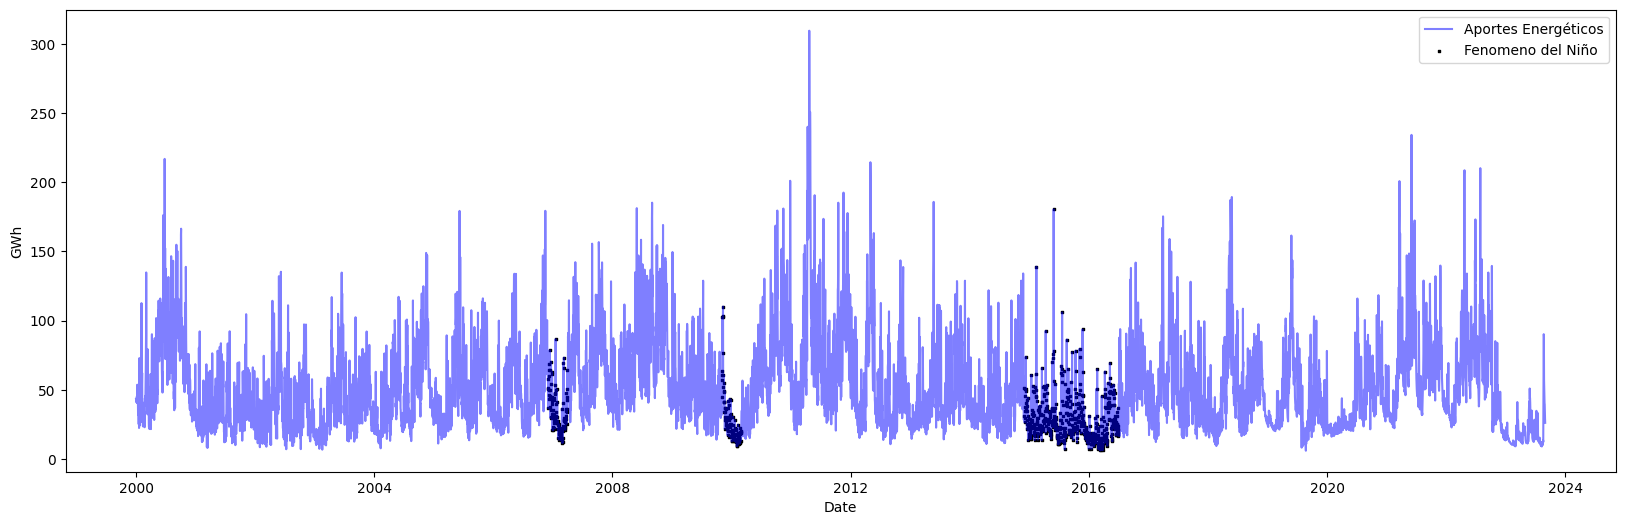

In [95]:
def plot_series(df):

  plt.figure(figsize=(20,6))

  plt.plot(df['Date'], df['AporCaudal'], label='Aportes Energéticos',color='blue', alpha=0.5)

  # Periodos de Niño
  df_nino=df[df['ENOS']]
  plt.scatter(df_nino['Date'], df_nino['AporCaudal'], label='Fenomeno del Niño',color='black', marker='s', s=1.5)

  plt.xlabel('Date')
  plt.ylabel('GWh')

  plt.legend()
  plt.show()


plot_series(df)

### Variables Meteorologicas

In [96]:
def read_csv(path):
    dfs= [ pd.read_csv(os.path.join(path, file),index_col=0,parse_dates=True) 
        for file in os.listdir(path) if file.endswith('.csv') and 'Aportes' not in file
    ]
    
    return pd.concat(dfs, axis=1).reset_index().rename(columns={'index':'Date'})

df_meteorological = read_csv(os.getcwd())

### Dataset Aportes

In [98]:
df=df_meteorological.merge(df, on='Date', how='right')
df.head()
df.to_csv('Aportes.csv', index=False)